## Импорт необходимых модулей и пакетов, а также применение настроек для удобной работы с данными

In [1]:
import re
import imaplib
import email
import base64
from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from email.header import decode_header
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.cache_size = 2000  # Увеличить лимит кэшированных объектов до 2к

pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

## Подключение к почтовому ящику и сам парсинг 

In [2]:
username = "**********"
pswd = "**********"
imap_server = "imap.yandex.ru"

imap = imaplib.IMAP4_SSL(imap_server)
print(imap.login(username, pswd))
print(imap.select("INBOX")) # переход ко входящим сообщениям

('OK', [b'LOGIN Completed.'])
('OK', [b'13553'])


In [3]:
result, data = imap.search(None, 'FROM "no-reply@support-uber.com"') # нахождение писем от Uber
msg_ids = (data[0].split()) # все письма от "no-reply@support-uber.com"

list_of_dates = []
list_of_trips = []
list_if_id_trips = []

for msg_id in msg_ids:
    result, list_data = imap.fetch(msg_id, 'RFC822')
    msg = email.message_from_bytes(list_data[0][1])
    id_trip = msg_id.decode('utf-8')
    list_if_id_trips.append(id_trip)
    subject = msg.get("Subject")
    decoded_parts = decode_header(subject)
    subject_str = ''.join(part.decode(enc or 'utf-8') if isinstance(part, bytes) else part for part, enc in decoded_parts)
    match = re.search(r'(\d{1,2}) ([а-яА-Я]+) (\d{4})', subject_str) # извлечение даты из темы сообщения - "13 апреля 2025"
    if match:
        day, month_str, year = match.groups()
        months = {
                'января': '01', 'февраля': '02', 'марта': '03', 'апреля': '04', 'мая': '05', 'июня': '06', 'июля': '07', 'августа': '08',
                'сентября': '09', 'октября': '10', 'ноября': '11', 'декабря': '12'
                }
        month = months[month_str]
        date_str = f"{day}.{month}.{year}"
        date = pd.to_datetime(date_str, format='%d.%m.%Y')
        list_of_dates.append(date)
    else:
        list_of_dates.append(None)
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            html_bytes = part.get_payload(decode=True)
            charset = part.get_content_charset() or 'utf-8'
            html_str = html_bytes.decode(charset, errors='replace')
            soup = BeautifulSoup(html_str, 'html.parser')
            tag = soup.body
            cleaned = [s.strip() for s in tag.stripped_strings if s.strip()][0:21] # извлечение нужноц иныормации
            list_of_trips.append(cleaned)

## Создание датафрейма

In [4]:
df = pd.DataFrame(list_of_trips)
df['id_trips'] = list_if_id_trips
df["date"] = list_of_dates
df["date"] = pd.to_datetime(df["date"])
df = df.drop(0, axis = 0) # удаляем письмо с подтверждением подписки на отчеты

In [5]:
columns = (["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", '18', "19", "20", "id_trips", "date"])
df.columns = columns

In [6]:
df["date"].dt.year.value_counts() #.sum() количество поездок за 5 лет

date
2023    75
2022    60
2024    46
2021    19
2025     9
Name: count, dtype: int64

### За 5 лет использования Uber поменял формат/структуру отчетов о поездках, поэтому в итоговом df после парсинга некоторые значения съехали в другие столбцы, процесс приведения всего к одной форме представлен ниже

- 62 отмененые поездки из 209

In [7]:
df.sample(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,id_trips,date
18,15:07,"улица Богдана Хмельницкого, 117к1",15:24,ЧувашГосснаб,186 ₽,Тариф,UberX,Стоимость,186 ₽,Оплата,****1873,186 ₽,Водитель: Медведев Евгений Александрович,белый Granta,Е694ХТ21,"Партнёр: ИП Офицеров Дмитрий Станиславович, ОГ...",+79952979075,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1497,2022-08-25
92,08:18,"улица Богдана Хмельницкого, 117к1",08:32,"улица Байдукова, 23",Тариф,UberX,Наличные,белый Granta,М553РА21,+79935535288,Забыли вещи в такси или другой вопрос по поезд...,Больше не получать отчёты о поездках,None,None,None,None,None,None,None,None,None,2817,2023-02-02
167,04:14,Меридиан,04:29,"улица Богдана Хмельницкого, 117к1",224 ₽,Тариф,UberX,Общая стоимость,224 ₽,Наличные,224 ₽,Получатель платежа,Логашенко Константин Александрович,Водитель:,Логашенко Константин Александрович,серый Granta,Е253КХ87,Перевозчик,Партнёр: Логашенко Константин Александрович,+79680406080,Забыли вещи в такси или другой вопрос по поезд...,6738,2024-01-15
39,22:29,"улица Богдана Хмельницкого, 117к1",22:36,"Московский проспект, 27",196 ₽,Тариф,UberX,Стоимость,196 ₽,Оплата,****1873,196 ₽,Водитель: Тверсков Сергей Владимирович,белый Renault Logan,К260НР21,"Партнёр: ИП Руссакова Ирина Диомидовна, ОГРН 3...",+78352380500,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1518,2022-07-23
188,01:21,"улица Гарибальди, 1А",01:49,"Ильинский бульвар, 8",944 ₽,Тариф,UberX,Общая стоимость,944 ₽,Способ оплаты\n ...,944 ₽,Получатель платежа,"ООО ""УК МАРМАГ""",Водитель:,Тагиров Кимран Касумович,жёлтый Volkswagen Polo,М878КК797,Перевозчик,"Партнёр: ООО ""УК МАРМАГ""",+74951444414,Забыли вещи в машине или другой вопрос по поез...,13289,2024-04-02


### В полученном мной датафрейме есть особенность, которая заключается в расположении данных, а именно их несостыковка.

- Так, например, записи в 4-ой и 5-ой колонке отличаются. Если к ним присмотреться, то можно найти паттерн: в 5-ой колонке должно быть указано слово "Тариф" - это будет означать, что поездка была. Если же этого слова нет в 5-ой колонке - поездка была отменена. 

In [8]:
df_base_with_tariff = df[df["5"] == "Тариф"].copy() # отбираает только успешные поездки 

df_base_with_tariff = df_base_with_tariff.drop(["4", "5", "7"], axis=1) # удаляем ненужные колонки (повторяющиеся и неполезные данные)
df_base_with_tariff["9"] = df_base_with_tariff['9'].apply(lambda k: k.split()[-1].replace("(СБП)", "СПБ")) # запись СПБ получилась длинной - сократил
mask = ~df_base_with_tariff['10'].str.contains('₽')
df_base_with_tariff["10"] = df_base_with_tariff["10"].where(mask, np.nan) # там где есть значение "₽" - ставим пропуск, тк в этой колокне будет указаны последние 4 цифры карты

df_base_with_tariff["11"].value_counts() # показалась запись Водитель: Корнилов Денис Геннадьевич, которая там не должна быть - c 11 колонки начинается смещение записей 
check = df_base_with_tariff[df_base_with_tariff["11"] == "Водитель: Корнилов Денис Геннадьевич"] # решил сдвинуть значения ячеек вправо на 1 шаг, чтобы не сломать логику 

cols_for_11 = ['11', '12', '13', '14', '15', '16'] # для 33 индекса сдвинули вправо на 1 все ячейки начиная с 11-16
row_idx = 33
original = [df_base_with_tariff.at[row_idx, col] for col in cols_for_11] # текущие значения в этих ячейках
shifted = [''] + original[:-1] # добавил в начало пустую запись в ячейку, а из конца наоборот убрал
for col, value in zip(cols_for_11, shifted):
    df_base_with_tariff.at[row_idx, col] = value
    
df_base_with_tariff = df_base_with_tariff.drop("11", axis=1) # после мува ячеек вправо удалил 11 колонку, тк она не важна 
df_base_with_tariff.shape

(147, 19)

In [9]:
# 1 df (0 - 73)
# Деление записей по структуре и приведение к одной (до 73 индекса записи имеют структуру ниже)

df_do_136 = df_base_with_tariff.loc[:73]
df_do_136

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
1,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1477,2022-09-06
2,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1478,2022-09-06
3,20:27,"улица Богдана Хмельницкого, 117к1",20:44,"Социалистическая улица, 7к2",UberX,182 ₽,Оплата,****1873,Водитель: Эргашев Акбарали Соатович,белый Chevrolet Cobalt,Е347РО21,Партнёр: Эргашев Акбарали Соатович,+79603040812,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1482,2022-08-20
4,11:33,"улица Богдана Хмельницкого, 117к1",11:40,"улица Юрия Гагарина, 22А",UberX,76 ₽,Оплата,****1873,Водитель: Николаев Владимир Леонидович,серый Granta,К504НР21,"Партнёр: ИП Пучков Иван Александрович, ОГРН 32...",+79003301600,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1483,2022-05-27
5,12:05,"проспект Максима Горького, 11",12:17,"улица Богдана Хмельницкого, 117к1",UberX,125 ₽,Оплата,****1873,Водитель: Яковлев Игорь Константинович,серый Volkswagen Polo,М715КМ152,"Партнёр: ИП Медаков Валерий Федорович, ОГРН 31...",+79370105855,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1484,2022-08-19
6,15:24,"улица Богдана Хмельницкого, 117к1",15:32,"улица Карла Маркса, 31",UberX,249 ₽,Оплата,****1873,Водитель: Плисов Арнольд Михайлович,чёрный Kalina,В183РУ21,"Партнёр: ООО ""ТАКСИ САН-ДОР"", ОГРН 1182130008125",+79153868216,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1485,2022-07-24
7,08:51,"улица Богдана Хмельницкого, 117к1",08:55,"Дубравная улица, 5к1",UberX,183 ₽,Оплата,****1873,Водитель: Питернов Александр Юрьевич,синий Granta,К575МС21,"Партнёр: ИП Коновалова Наталья Владимировна, О...",+79632155943,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1486,2022-08-08
8,16:18,"Авиамоторная улица, 55к31",16:23,"Авиамоторная улица, 43/24",UberX,132 ₽,Оплата,****1873,Водитель: Недачин Александр Александрович,белый Kia Rio,У203ММ77,Партнёр: Недачин Александр Александрович,+79096540088,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1487,2022-05-24
9,14:42,"Авиамоторная улица, 55к31",14:47,"Авиамоторная улица, 43/24",UberX,131 ₽,Оплата,****1873,Водитель: Кожобеков Тилек Курманбекович,жёлтый Kia Rio,Х831ВО799,"Партнёр: ИП Абашидзе Нодари Ревазович, ОГРН 31...",+79852057756,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1488,2022-06-20
10,20:26,"улица Богдана Хмельницкого, 117к1",20:39,Железнодорожный вокзал,UberX,108 ₽,Оплата,****1873,Водитель: Кириллов Михаил Николаевич,белый Granta,К111НС21,"Партнёр: ООО ""РАУТ"", ОГРН 1062130001779",+79520281468,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1489,2022-06-29


In [10]:
df_base_with_tariff

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
1,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1477,2022-09-06
2,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1478,2022-09-06
3,20:27,"улица Богдана Хмельницкого, 117к1",20:44,"Социалистическая улица, 7к2",UberX,182 ₽,Оплата,****1873,Водитель: Эргашев Акбарали Соатович,белый Chevrolet Cobalt,Е347РО21,Партнёр: Эргашев Акбарали Соатович,+79603040812,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1482,2022-08-20
4,11:33,"улица Богдана Хмельницкого, 117к1",11:40,"улица Юрия Гагарина, 22А",UberX,76 ₽,Оплата,****1873,Водитель: Николаев Владимир Леонидович,серый Granta,К504НР21,"Партнёр: ИП Пучков Иван Александрович, ОГРН 32...",+79003301600,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1483,2022-05-27
5,12:05,"проспект Максима Горького, 11",12:17,"улица Богдана Хмельницкого, 117к1",UberX,125 ₽,Оплата,****1873,Водитель: Яковлев Игорь Константинович,серый Volkswagen Polo,М715КМ152,"Партнёр: ИП Медаков Валерий Федорович, ОГРН 31...",+79370105855,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1484,2022-08-19
6,15:24,"улица Богдана Хмельницкого, 117к1",15:32,"улица Карла Маркса, 31",UberX,249 ₽,Оплата,****1873,Водитель: Плисов Арнольд Михайлович,чёрный Kalina,В183РУ21,"Партнёр: ООО ""ТАКСИ САН-ДОР"", ОГРН 1182130008125",+79153868216,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1485,2022-07-24
7,08:51,"улица Богдана Хмельницкого, 117к1",08:55,"Дубравная улица, 5к1",UberX,183 ₽,Оплата,****1873,Водитель: Питернов Александр Юрьевич,синий Granta,К575МС21,"Партнёр: ИП Коновалова Наталья Владимировна, О...",+79632155943,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1486,2022-08-08
8,16:18,"Авиамоторная улица, 55к31",16:23,"Авиамоторная улица, 43/24",UberX,132 ₽,Оплата,****1873,Водитель: Недачин Александр Александрович,белый Kia Rio,У203ММ77,Партнёр: Недачин Александр Александрович,+79096540088,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1487,2022-05-24
9,14:42,"Авиамоторная улица, 55к31",14:47,"Авиамоторная улица, 43/24",UberX,131 ₽,Оплата,****1873,Водитель: Кожобеков Тилек Курманбекович,жёлтый Kia Rio,Х831ВО799,"Партнёр: ИП Абашидзе Нодари Ревазович, ОГРН 31...",+79852057756,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1488,2022-06-20
10,20:26,"улица Богдана Хмельницкого, 117к1",20:39,Железнодорожный вокзал,UberX,108 ₽,Оплата,****1873,Водитель: Кириллов Михаил Николаевич,белый Granta,К111НС21,"Партнёр: ООО ""РАУТ"", ОГРН 1062130001779",+79520281468,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1489,2022-06-29


In [11]:
# Также записи из df_base_with_tariff отличабтся между собой - в 12-ой колонке в некоторых местах есть "Получатель платежа", а должно быть ФИО водителя 
df_est_poluchatel_platezha = df_base_with_tariff[(df_base_with_tariff["12"] == "Получатель платежа")]

# Перезаписвание значений ячеек путем мува - значение в 15-ой колонке заменилось на значение из 12-ой и так я заменил значения с 15-20 колонках
from_cols = ["15", "16", "17", "19", "20"]
to_cols = [str(i) for i in range(12, 17)]
for to_col, from_col in zip(to_cols, from_cols):
    df_est_poluchatel_platezha[to_col] = df_est_poluchatel_platezha[from_col]

# 2 df (136 - 146)
df_est_poluchatel_platezha

C:\Users\nikol\AppData\Local\Temp\ipykernel_33524\4272739593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_est_poluchatel_platezha[to_col] = df_est_poluchatel_platezha[from_col]


,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
136,01:27,"улица Э.М. Юрьева, 1А",01:40,"улица Богдана Хмельницкого, 117к1",UberX,158 ₽,Наличные,•••• 1873,Хисамов Ришат Фиргатьевич,белый Granta,К570КМ21,Партнёр: Хисамов Ришат Фиргатьевич,+79876697267,К570КМ21,Перевозчик,Партнёр: Хисамов Ришат Фиргатьевич,+79876697267,5796,2023-11-04
137,20:35,"улица Богдана Хмельницкого, 117к1",20:48,Волжский,UberX,186 ₽,Наличные,•••• 1873,Пушков Юрий Александрович,чёрный Vesta,Е092СМ21,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,Е092СМ21,Перевозчик,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,5803,2023-11-04
138,08:23,"улица Э.М. Юрьева, 1А",08:35,"улица Богдана Хмельницкого, 117к1",UberX,227 ₽,Наличные,•••• 1873,Яковлев Альберт Сергеевич,белый Granta,М909СК21,Партнёр: Яковлев Альберт Сергеевич,+79530108497,М909СК21,Перевозчик,Партнёр: Яковлев Альберт Сергеевич,+79530108497,5804,2023-11-05
139,19:25,"улица Богдана Хмельницкого, 117к1",19:34,Пригородный автовокзал,UberX,129 ₽,Наличные,•••• 1873,Мухин Александр Васильевич,чёрный Hyundai Solaris,М912ОЕ21,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,М912ОЕ21,Перевозчик,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,5815,2023-11-06
140,04:56,"Щёлковское шоссе, 77",05:20,"улица Юности, 3",UberX,1538 ₽,Наличные,•••• 1873,Басангов Никита Валерьевич,жёлтый Kia Rio,М441РН193,Партнёр: ИП Ефремов Максим Игоревич,+79264988469,М441РН193,Перевозчик,Партнёр: ИП Ефремов Максим Игоревич,+79264988469,5817,2023-11-07
141,02:13,"Ильинский бульвар, 8",04:42,"Шереметьево, Терминал В, Зона вылета",UberX,3930 ₽,Наличные,•••• 1873,Эмилбек Уулу Арзыкул,жёлтый Kia Rio,РЕ49977,Партнёр: ИП Базарбаева Тансулуу Канатовна,+79152007888,РЕ49977,Перевозчик,Партнёр: ИП Базарбаева Тансулуу Канатовна,+79152007888,5887,2023-11-12
142,22:34,"улица Удальцова, 55",22:41,"Ленинский проспект, 88",UberX,335 ₽,Наличные,•••• 1873,Аширали Уулу Гулжигит,белый Kia Rio,О869МК790,Партнёр: ИП Конкошов Саидкасым Маматкасымович,+79645801818,О869МК790,Перевозчик,Партнёр: ИП Конкошов Саидкасым Маматкасымович,+79645801818,6241,2023-12-07
143,01:42,"Ленинский проспект, 88",02:25,"улица Юности, 3",UberX,1606 ₽,Наличные,•••• 1873,Хасболатов Джамалдин Карагишиевич,белый Kia Rio,К861СР750,Партнёр: Хасболатов Джамалдин Карагишиевич,+79264673639,К861СР750,Перевозчик,Партнёр: Хасболатов Джамалдин Карагишиевич,+79264673639,6362,2023-12-17
144,13:02,"улица Юности, 3",13:11,"Городская поликлиника № 66, филиал № 1",UberX,373 ₽,Наличные,•••• 1873,Парсаданян Эдгар Сейранович,белый Kia Rio,У900ЕР71,Партнёр: Индивидуальный предприниматель Тевс А...,+79067824040,У900ЕР71,Перевозчик,Партнёр: Индивидуальный предприниматель Тевс А...,+79067824040,6377,2023-12-18
145,14:58,"улица Руднёвка, 27",15:06,"улица Юности, 3",UberX,311 ₽,Наличные,•••• 1873,Мирзоян Вардан Валикоевич,белый Nissan Almera,О994РУ777,Партнёр: Мирзоян Вардан Валикоевич,+79263520865,О994РУ777,Перевозчик,Партнёр: Мирзоян Вардан Валикоевич,+79263520865,6381,2023-12-18


In [12]:
# то же самое и для остальных записей (ячейка выше) 

df_net_poluchatel_platezha = df_base_with_tariff[(df_base_with_tariff["12"] != "Получатель платежа")]
df_net_poluchatel_platezha = df_net_poluchatel_platezha.loc[147:]

from_cols = ["14", "15", "16", "18", "19"]
to_cols = ["12", "13", "14", "15", "16"]
for to_col, from_col in zip(to_cols, from_cols):
    df_net_poluchatel_platezha[to_col] = df_net_poluchatel_platezha[from_col]
    
# 3 df (147 - end) ************************************************************************************************************************************************************************
df_net_poluchatel_platezha.shape

(63, 19)

In [13]:
# итоговая таблица, которая содержит 147 записей с успешными поездками (оставшиеся - не успешные (62), тк были не начаты даже - отмененные)
# сборка итогового df из 3 df

df_new_original_147 = pd.concat([df_do_136, df_est_poluchatel_platezha, df_net_poluchatel_platezha], ignore_index=True)
df_new_original_147.head()

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
0,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1477,2022-09-06
1,15:20,"Авиамоторная улица, 55к31",15:25,"Авиамоторная улица, 43/24",UberX,176 ₽,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1478,2022-09-06
2,20:27,"улица Богдана Хмельницкого, 117к1",20:44,"Социалистическая улица, 7к2",UberX,182 ₽,Оплата,****1873,Водитель: Эргашев Акбарали Соатович,белый Chevrolet Cobalt,Е347РО21,Партнёр: Эргашев Акбарали Соатович,+79603040812,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1482,2022-08-20
3,11:33,"улица Богдана Хмельницкого, 117к1",11:40,"улица Юрия Гагарина, 22А",UberX,76 ₽,Оплата,****1873,Водитель: Николаев Владимир Леонидович,серый Granta,К504НР21,"Партнёр: ИП Пучков Иван Александрович, ОГРН 32...",+79003301600,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1483,2022-05-27
4,12:05,"проспект Максима Горького, 11",12:17,"улица Богдана Хмельницкого, 117к1",UberX,125 ₽,Оплата,****1873,Водитель: Яковлев Игорь Константинович,серый Volkswagen Polo,М715КМ152,"Партнёр: ИП Медаков Валерий Федорович, ОГРН 31...",+79370105855,Забыли вещи в Uber или другой вопрос по поездк...,Больше не получать отчёты о поездках,None,None,1484,2022-08-19


In [14]:
# df с отмененными поездками (их нужно будет склеить с df_new_original_147)
df_base_not_tariff = df[df["5"] != "Тариф"].copy()
df_base_not_tariff = df_base_not_tariff.drop("4", axis=1)

from_cols = ["5", "6", "7", "8", "9"]
to_cols = ["6", "9", "13", "14", "16"]
for to_col, from_col in zip(to_cols, from_cols):
    df_base_not_tariff[to_col] = df_base_not_tariff[from_col]
    
df_base_not_tariff = df_base_not_tariff.drop(["5", "7", "11"], axis=1)
df_base_not_tariff[["8", "9", "10", "12", "15", "16"]] = np.nan
df_base_not_tariff.sample(n=4)

,0,1,2,3,6,8,9,10,12,13,14,15,16,17,18,19,20,id_trips,date
115,01:15,Pipl Bar,01:29,"Авиамоторная улица, 55к31",UberX,NaN,NaN,NaN,NaN,жёлтый Volkswagen Polo,У473КР797,NaN,NaN,None,None,None,None,4356,2023-07-02
113,07:07,"Авиамоторная улица, 55к31",07:12,"Авиамоторная улица, 43/24",UberX,NaN,NaN,NaN,NaN,белый Skoda Octavia,С836МЕ797,NaN,NaN,None,None,None,None,4017,2023-06-08
80,05:17,"улица Текстильщиков, 8к15А",05:28,"улица Богдана Хмельницкого, 117к1",UberX,NaN,NaN,NaN,NaN,серый Hyundai Solaris,К255ТХ21,NaN,NaN,None,None,None,None,2518,2023-01-01
118,22:00,"улица Богдана Хмельницкого, 117к1",22:10,Центральная библиотека имени Маяковского В. В.,UberX,NaN,NaN,NaN,NaN,серый Granta,Е786СР21,NaN,NaN,None,None,None,None,4560,2023-07-18


In [15]:
# Итогшовый df, с котором можно уже работать
df_total = pd.concat([df_base_not_tariff, df_new_original_147], ignore_index=True)
df_total = df_total.drop(["17", "18", "19", "20"], axis=1) # удаление ненужных столбцов

# Переименование столбцов в понятные имена
new_columns = (["start_time", "a_point", "end_time", "b_point", "tariff", "cost", "payment_method", "card", "driver", "auto", "auto_number", "transporter", "telephone", "id_trips", "date"])
df_total.columns = new_columns
df_total

# мув колонки с id поездки в самое начало
first_column = df_total.pop('id_trips')
df_total.insert(0, 'id_trips', first_column)
df_total.sample(n=10)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date
186,13288,05:42,Choice lounge club,05:49,"улица Богдана Хмельницкого, 117к1",UberX,239 ₽,СПБ,NaN,Казаков Александр Алексеевич,серый Kia Rio,Х005АО21,Партнёр: ИП Казаков Александр Алексеевич,+79063816262,2024-03-22
15,2811,13:30,"Привокзальная улица, 1Ж",13:40,"улица Богдана Хмельницкого, 117к1",UberX,NaN,NaN,NaN,NaN,белый Vesta,Е259ОР21,NaN,NaN,2023-02-01
35,3619,06:57,"Авиамоторная улица, 55к31",07:03,"Авиамоторная улица, 43/24",UberX,NaN,NaN,NaN,NaN,жёлтый Hyundai Solaris,ОТ45277,NaN,NaN,2023-05-04
143,6377,13:02,"улица Юности, 3",13:11,"Городская поликлиника № 66, филиал № 1",UberX,373 ₽,Наличные,•••• 1873,Парсаданян Эдгар Сейранович,белый Kia Rio,У900ЕР71,Партнёр: Индивидуальный предприниматель Тевс А...,+79067824040,2023-12-18
48,4577,08:35,"улица Богдана Хмельницкого, 117к1",08:46,"проспект Максима Горького, 24",UberX,NaN,NaN,NaN,NaN,серый Vesta,К113КА21,NaN,NaN,2023-07-20
188,13290,20:52,"Большая Татарская улица, 5с9",21:16,"улица Архитектора Власова, 17",UberX,689 ₽,СПБ,NaN,Алиев Сабир Вагиф Оглы,жёлтый Skoda Octavia,О927ВХ799,Партнёр: Индивидуальный предприниматель Омаров...,+79152690824,2024-04-27
106,1524,10:51,"Свободный проспект, 32",11:10,"улица Юности, 3",UberX,339 ₽,Оплата,****1873,Водитель: Токтоходжаев Нурзатбек Кубанычбекович,жёлтый Skoda Rapid,ОЕ36277,"Партнёр: ИП Андрусенко Дмитрий Георгиевич, ОГР...",+74999949109,2022-06-12
189,13291,03:37,Проспект Вернадского,04:01,"Ильинский бульвар, 8",UberX,1106 ₽,СПБ,NaN,Мыктыбек Уулу Адилет,жёлтый JAC J7,Н126ОА797,"Партнёр: ООО ""УК МАРМАГ""",+74951444414,2024-05-26
136,5803,20:35,"улица Богдана Хмельницкого, 117к1",20:48,Волжский,UberX,186 ₽,Наличные,•••• 1873,Пушков Юрий Александрович,чёрный Vesta,Е092СМ21,Партнёр: ГОРОДСКОЕ ОБЪЕДИНЕНИЕ СЛУЖБ ТАКСИ,+78352601600,2023-11-04
115,1533,00:56,"Авиамоторная улица, 49/1",01:01,"Авиамоторная улица, 55к31",UberX,239 ₽,Оплата,****3154,Водитель: Асыранкулов Нургазы,жёлтый Volkswagen Polo,РЕ80077,"Партнёр: ИП Толонбаев Гулчоро Зулпукарович, ОГ...",+79255516100,2021-10-13


In [16]:
# Преобразование типов данных для последующей удобной работы

df_total[["tariff", "payment_method"]] = df_total[["tariff", "payment_method"]].astype("category")
df_total["cost"] = df_total["cost"].apply(lambda x: int(str(x).replace('₽', '').replace('\u202f', '').replace(' ', '')) if pd.notnull(x) else None)
df_total["start_time"] = pd.to_datetime(df_total["start_time"], format="%H:%M").dt.time
df_total["end_time"] = pd.to_datetime(df_total["end_time"], format='%H:%M').dt.time
df_total["driver_hash"] = df_total["driver"].apply(hash)

In [17]:
# Подсчет количества минут в поездках

def time_diff_minutes(t1, t2):
    m1 = t1.hour * 60 + t1.minute
    m2 = t2.hour * 60 + t2.minute
    diff = m2 - m1
    if diff < 0:  # если был переход через полночь
        diff += 24 * 60
    return diff  # только количество минут, целое число

df_total['in_time'] = [time_diff_minutes(s, e) for s, e in zip(df_total['start_time'], df_total['end_time'])]
df_total.sample(n=5)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date,driver_hash,in_time
33,3435,23:02:00,"шоссе Энтузиастов, 22/18",23:08:00,"Авиамоторная улица, 55к31",UberX,NaN,NaN,NaN,NaN,белый Kia Rio,У987КР790,NaN,NaN,2023-04-14,178577581551,6
128,1546,08:59:00,"Привокзальная улица, 1",09:08:00,"улица Богдана Хмельницкого, 117к1",UberX,79.0,Оплата,****3154,Водитель: Пантилов Александр Сергеевич,чёрный Renault Laguna,Е346КТ21,Партнёр: Пантилов Александр Сергеевич,+79033583204,2021-10-31,5382902320693959747,9
186,13288,05:42:00,Choice lounge club,05:49:00,"улица Богдана Хмельницкого, 117к1",UberX,239.0,СПБ,NaN,Казаков Александр Алексеевич,серый Kia Rio,Х005АО21,Партнёр: ИП Казаков Александр Алексеевич,+79063816262,2024-03-22,-8121933645020584457,7
143,6377,13:02:00,"улица Юности, 3",13:11:00,"Городская поликлиника № 66, филиал № 1",UberX,373.0,Наличные,•••• 1873,Парсаданян Эдгар Сейранович,белый Kia Rio,У900ЕР71,Партнёр: Индивидуальный предприниматель Тевс А...,+79067824040,2023-12-18,-345033929056834907,9
121,1539,15:23:00,"Авиамоторная улица, 55к31",15:29:00,"Авиамоторная улица, 43/24",UberX,153.0,Оплата,****3154,Водитель: Таиров Сталбек Бурканбекович,белый Hyundai Solaris,К665УЕ750,"Партнёр: ИП Арзуманян М.Г., ОГРН 316774600082590",+79670036580,2021-10-05,-1771192538706898202,6


## Немного инфо о данных:

In [18]:
x = df_total.shape[0]
y = df_total.shape[1]

print(f"Таблица содержит {x} записей и {y} столбцов")

Таблица содержит 209 записей и 17 столбцов


In [19]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_trips        209 non-null    object        
 1   start_time      209 non-null    object        
 2   a_point         209 non-null    object        
 3   end_time        209 non-null    object        
 4   b_point         209 non-null    object        
 5   tariff          209 non-null    category      
 6   cost            147 non-null    float64       
 7   payment_method  147 non-null    category      
 8   card            83 non-null     object        
 9   driver          147 non-null    object        
 10  auto            209 non-null    object        
 11  auto_number     209 non-null    object        
 12  transporter     147 non-null    object        
 13  telephone       147 non-null    object        
 14  date            209 non-null    datetime64[ns]
 15  driver

In [20]:
succes = df_total[~df_total["telephone"].isna()].shape[0]
fail = df_total[df_total["telephone"].isna()].shape[0] 
procent = fail/succes

print("Общее количево поездок на такси:-", df_total.shape[0])
print(f"Отмененные поездки:- {fail}", f"| Совершенные поездки:- {succes}")
print(f"Отменённые/Совершённые:- {int(procent*100)}%")

Общее количево поездок на такси:- 209
Отмененные поездки:- 62 | Совершенные поездки:- 147
Отменённые/Совершённые:- 42%


In [21]:
# Добавление дня, месяца и года в отдльные столбцы 

df_an = df_total.copy()
df_an["year"] = df_an["date"].dt.year
df_an["month"] = df_an["date"].dt.month#_name() 
df_an["day"] = df_an["date"].dt.day_name()
df_an.sample(n=3)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto,auto_number,transporter,telephone,date,driver_hash,in_time,year,month,day
62,1477,15:20:00,"Авиамоторная улица, 55к31",15:25:00,"Авиамоторная улица, 43/24",UberX,176.0,Оплата,****1873,Водитель: Алимбаев Расулжан Саабырович,белый Hyundai Solaris,В487ТР62,"Партнёр: ИП Сыдыков Талгат Женишбекович, ОГРН ...",+79254090933,2022-09-06,-8764177861142200372,5,2022,9,Tuesday
79,1497,15:07:00,"улица Богдана Хмельницкого, 117к1",15:24:00,ЧувашГосснаб,UberX,186.0,Оплата,****1873,Водитель: Медведев Евгений Александрович,белый Granta,Е694ХТ21,"Партнёр: ИП Офицеров Дмитрий Станиславович, ОГ...",+79952979075,2022-08-25,-7685016442780537137,17,2022,8,Thursday
206,13308,19:41:00,"улица Богдана Хмельницкого, 117к1",19:55:00,V-lounge,UberX,295.0,СПБ,NaN,Александров Дмитрий Сергеевич,серый Nissan Leaf,М516СН21,Партнёр: Александров Дмитрий Сергеевич,+79603098299,2025-04-12,-8643526602905039596,14,2025,4,Saturday


<Axes: title={'center': 'Динамика поездок по годам'}, ylabel='year'>

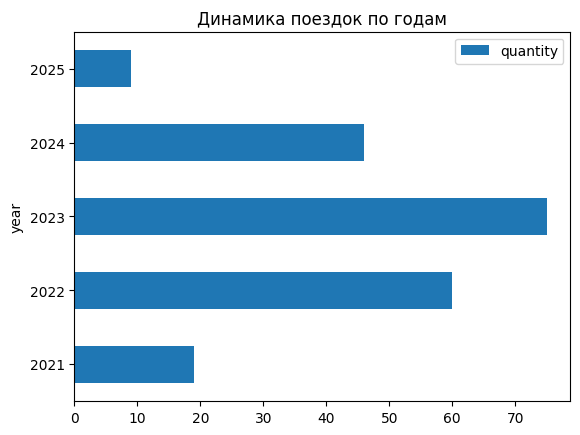

In [22]:
df_an.groupby("year", as_index=False)[["month"]] \
     .count() \
     .rename(columns={"month": "quantity"}) \
     .plot(x="year", y="quantity", kind="barh", title=("Динамика поездок по годам"))

In [23]:
# Динамика поездок, сгруппированная по году и месяцу

df_date_month = df_an.groupby(["year", "month"], as_index=False)[["id_trips"]].count().rename(columns={"id_trips": "quantity"})
df_date_month.head()

,year,month,quantity
0,2021,9,2
1,2021,10,7
2,2021,11,10
3,2022,5,7
4,2022,6,6


In [24]:
# Функции, которые избаляют слова: "Водитель" и "Партнёр" в начале содержимого ячеек в столбцах "driver" и "transporter"

def trans_d(s):
    if isinstance(s, str) and "Водитель:" in s:
        word = s.split()[1:]
        new_word = " ".join(word)
        return new_word
    return s

def trans_t(s):
    if isinstance(s, str) and "Партнёр:" in s:
        new_word = " ".join(s.split()[1:])
        if ", ОГРН" in new_word:
            return new_word.split(", ОГРН")[0].strip()
        return new_word.strip()
    return s  

In [25]:
# Цвет, марку авто, модель авто заносим в отдельные столбцы и удаляем столбец auto

df_an["color"] = df_an["auto"].apply(lambda k: k.split()[0])
df_an["car"] = df_an["auto"].apply(lambda k: k.split()[1])
df_an["car"] = df_an["car"].apply(lambda k: "Lada" if k in ["Granta", "Vesta", "Priora", "Kalina", "Largus", "XRAY"] else k)
df_an["car_model"] = df_an["auto"].apply(lambda k: k.split()[-1])

df_an = df_an.drop(columns="auto")

In [26]:
df_an["driver"] = df_an["driver"].apply(trans_d)
df_an["transporter"] = df_an["transporter"].apply(trans_t)

In [27]:
df_an.sample(n=3)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,auto_number,transporter,telephone,date,driver_hash,in_time,year,month,day,color,car,car_model
7,2520,16:52:00,"улица Богдана Хмельницкого, 109к1",17:00:00,Вкусно — и точка,UberX,NaN,NaN,NaN,NaN,К429РА21,NaN,NaN,2023-01-01,178577581551,8,2023,1,Sunday,серый,Skoda,Rapid
116,1534,20:33:00,"улица Богдана Хмельницкого, 117к1, подъезд 2",20:42:00,Железнодорожный вокзал,UberX,147.0,Оплата,****1873,Яковлев Сергей Николаевич,Е615СО21,ИП Селиверстов Александр Николаевич,+79058710796,2021-11-27,-6470210237017854807,9,2021,11,Saturday,белый,Lada,Vesta
203,13305,17:45:00,"улица Богдана Хмельницкого, 117к1",17:54:00,"Радужная улица, 1",UberX,162.0,СПБ,NaN,Шилов Никита Леонидович,Н887КУ21,Шилов Никита Леонидович,+79083033829,2025-03-23,6333521189093268344,9,2025,3,Sunday,коричневый,Lada,Vesta


In [28]:
# Сместили стобцы вперед (налево) - теперь инфо об авто идет сразк после столбца "driver"

color, car, car_model = df_an.pop("color"), df_an.pop("car"), df_an.pop("car_model")
pos_color, pos_car, pos_car_model = df_an.columns.get_loc('driver') + 1, df_an.columns.get_loc('driver') + 2, df_an.columns.get_loc('driver') + 3
df_an.insert(pos_color, 'color', color)
df_an.insert(pos_car, 'car', car)
df_an.insert(pos_car_model, 'car_model', car_model)

In [29]:
df_an.sample(n=6)

,id_trips,start_time,a_point,end_time,b_point,tariff,cost,payment_method,card,driver,color,car,car_model,auto_number,transporter,telephone,date,driver_hash,in_time,year,month,day
5,2516,19:26:00,"улица Богдана Хмельницкого, 117к1",19:36:00,"улица Текстильщиков, 8к15А",UberX,NaN,NaN,NaN,NaN,белый,Lada,Granta,К692ХА21,NaN,NaN,2022-12-31,178577581551,10,2022,12,Saturday
105,1523,11:55:00,"улица Богдана Хмельницкого, 117к1",12:05:00,"улица Коммунальная Слобода, 16А",UberX,177.0,Оплата,****1873,Багин Алексей Михайлович,белый,Renault,Sandero,С803АР750,ИП Афанасьева Вера Архиповна,+79196525224,2022-07-29,6378519396091205923,10,2022,7,Friday
20,2886,20:16:00,"улица Богдана Хмельницкого, 117к1",20:25:00,"улица Юрия Гагарина, 30к1",UberX,NaN,NaN,NaN,NaN,белый,Opel,Astra,У204РХ163,NaN,NaN,2023-02-09,178577581551,9,2023,2,Thursday
16,2813,20:38:00,"улица Богдана Хмельницкого, 117к1",20:48:00,"проспект Максима Горького, 10",UberX,NaN,NaN,NaN,NaN,белый,Renault,Stepway,К149ХН21,NaN,NaN,2023-02-01,178577581551,10,2023,2,Wednesday
91,1509,03:01:00,"улица Гузовского, 7",03:23:00,"улица Юрия Гагарина, 30к1",UberX,242.0,Оплата,****1873,Петров Алексей Алексеевич,чёрный,Lada,Priora,В153НА21,ИП Шустов А.Ю,+79196787200,2022-08-24,9168875555284947330,22,2022,8,Wednesday
100,1518,22:29:00,"улица Богдана Хмельницкого, 117к1",22:36:00,"Московский проспект, 27",UberX,196.0,Оплата,****1873,Тверсков Сергей Владимирович,белый,Renault,Logan,К260НР21,ИП Руссакова Ирина Диомидовна,+78352380500,2022-07-23,-5200161374018548556,7,2022,7,Saturday


In [30]:
df_an_scatter = df_an.copy()

## Разные графики

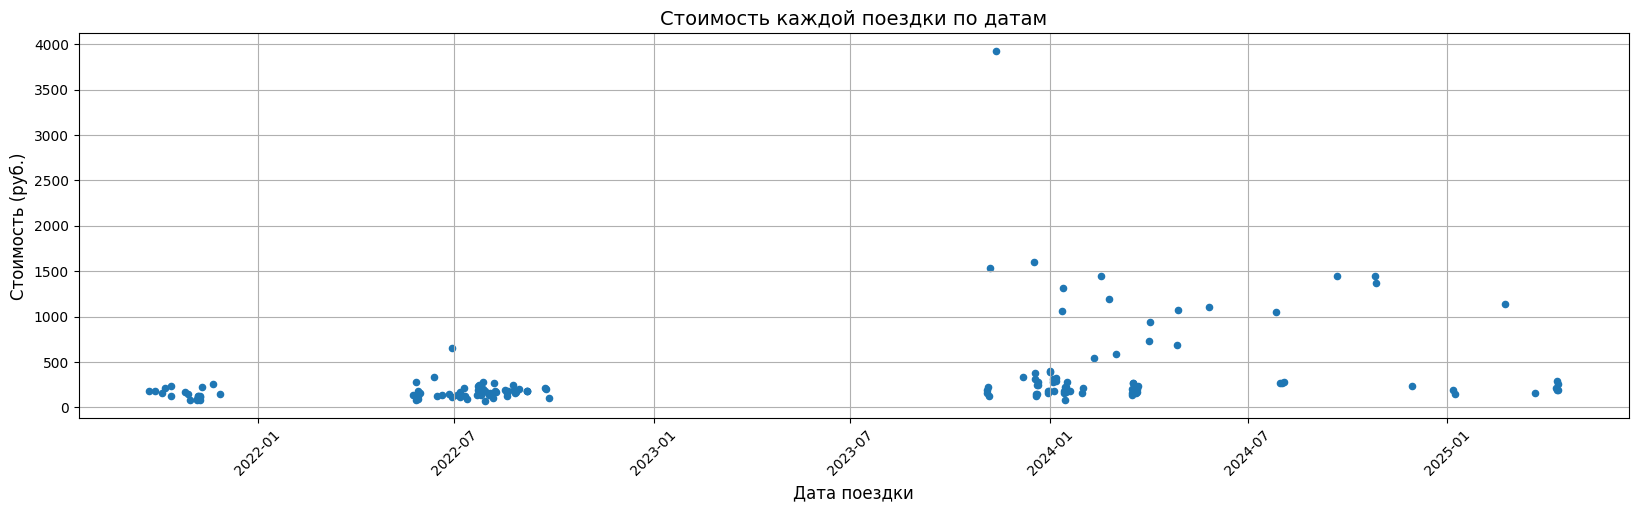

In [31]:
# Диаграмма рассеяния для всех успешных поездок, которая показывает разброс стоимостей и аномалии (например, поездка за приблизительно 4к).

df_an_scatter.query("cost > 0").plot.scatter(x="date", y="cost", figsize=(20, 5))
plt.title("Стоимость каждой поездки по датам", fontsize=14)
plt.xlabel("Дата поездки", fontsize=12)
plt.ylabel("Стоимость (руб.)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

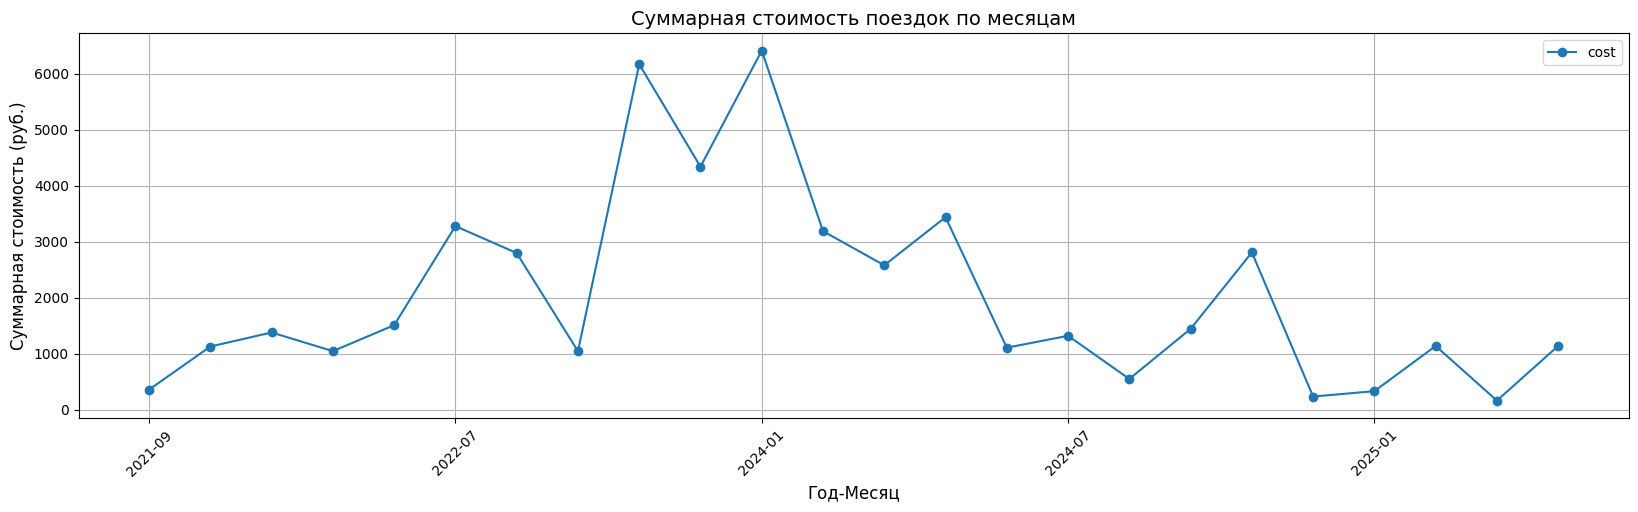

In [32]:
# Анализ тренда суммарных затрат по месяцам

df_an_scatter["year_month"] = df_an_scatter["date"].dt.to_period("M")
df_an_scatter = df_an_scatter.drop(columns="date")

x = df_an_scatter.groupby("year_month")["cost"].sum().reset_index().sort_values('year_month').query("cost > 0")
x["year_month"] = x["year_month"].astype(str)

# Линейный график с точками
x.plot.line(x="year_month", y="cost", figsize=(20, 5), marker='o')
plt.title("Суммарная стоимость поездок по месяцам", fontsize=14)
plt.xlabel("Год-Месяц", fontsize=12)
plt.ylabel("Суммарная стоимость (руб.)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Text(0, 0.5, 'Количество поездок')

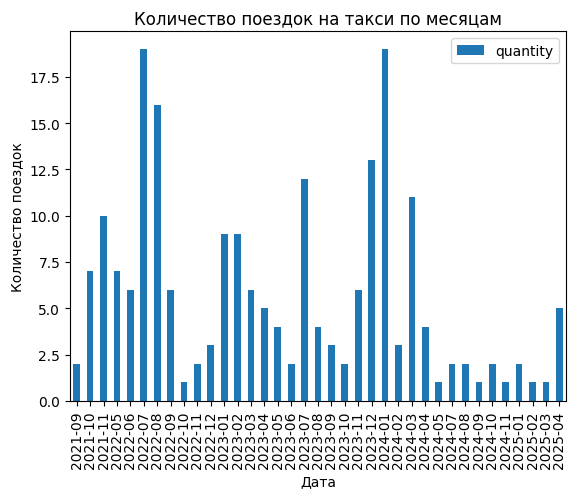

In [33]:
df_an_scatter.groupby("year_month")["car"].count().reset_index().rename(columns={"car": "quantity"}).set_index("year_month").plot(kind="bar", title=("Количество поездок на такси по месяцам")) # не учитваются отмененные поездки
plt.xlabel("Дата")
plt.ylabel("Количество поездок")

<Axes: title={'center': 'ТОП 10 марок авто'}, xlabel='car'>

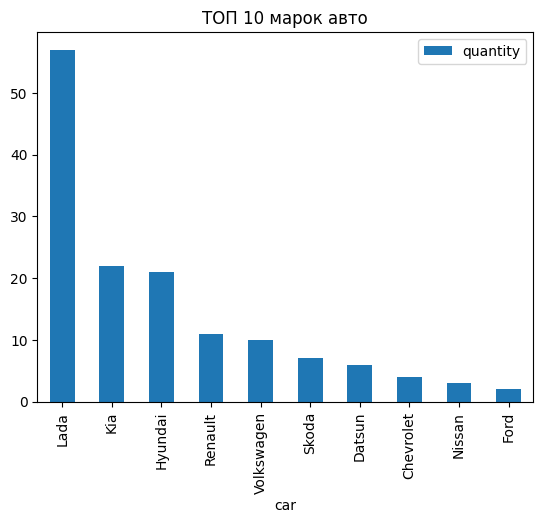

In [34]:
df_an_scatter.groupby("car")["cost"].count() \
             .reset_index() \
             .sort_values("cost", ascending=False) \
             .query("cost > 0") \
             .rename(columns={"cost": "quantity"}) \
             .set_index("car") \
             .head(10) \
             .plot(kind="bar", title=("ТОП 10 марок авто"))

<Axes: title={'center': 'ТОП 10 моделей авто'}, xlabel='car_model'>

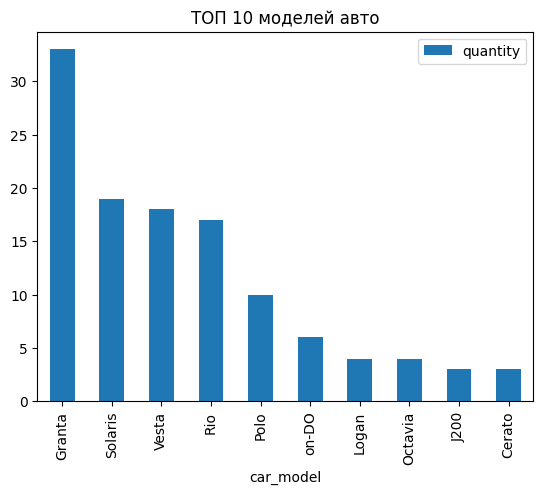

In [35]:
df_an_scatter.groupby("car_model")["cost"].count() \
             .reset_index() \
             .sort_values("cost", ascending=False) \
             .query("cost > 0") \
             .rename(columns={"cost": "quantity"}) \
             .set_index("car_model") \
             .head(10) \
             .plot(kind="bar", title=("ТОП 10 моделей авто"))

In [36]:
# Частота выбора тарифа 
df_an_scatter["tariff"].value_counts()

tariff
UberX     200
Select      6
Share       3
Name: count, dtype: int64

In [37]:
# Частота марок авто, выпавших на успешные поездки с тарифом UberX
df_an_scatter.query('tariff == "UberX" and cost > 0')["car"].value_counts().head(10)

car
Lada          56
Hyundai       21
Kia           19
Renault       11
Volkswagen    10
Skoda          6
Datsun         6
Chevrolet      4
Nissan         3
Ford           2
Name: count, dtype: int64

In [38]:
# Частота марок авто, выпавших на успешные поездки с тарифом Select
df_an_scatter.query('tariff == "Select" and cost > 0')["car"].value_counts().head(10)

car
Toyota     1
Kia        1
Skoda      1
Москвич    1
Name: count, dtype: int64

In [39]:
# Частота марок авто, выпавших на успешные поездки с тарифом Share
df_an_scatter.query('tariff == "Share" and cost > 0')["car"].value_counts().head(10)

car
Kia     2
Lada    1
Name: count, dtype: int64

In [40]:
x = df_an_scatter.query('cost > 0')["in_time"].mean().round(2)
print(f"Cреднее время пути - {x} минут.")

Cреднее время пути - 13.46 минут.


<Axes: xlabel='index', ylabel='cost'>

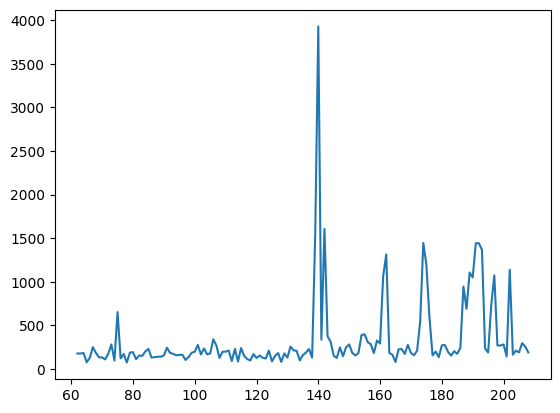

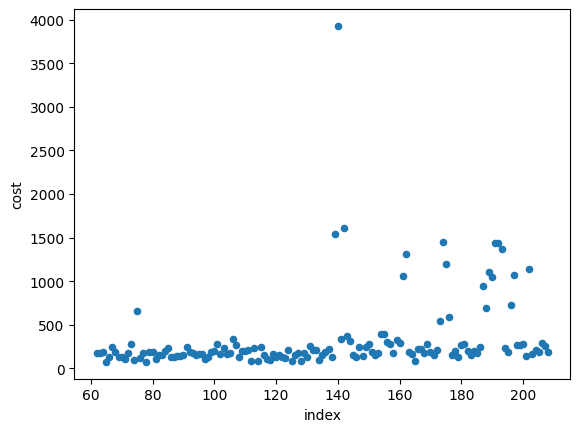

In [41]:
df_an_scatter.query('cost > 0')["cost"].plot(), # линейный график по стоимости успешных поездок
df_an_scatter.query('cost > 0').reset_index().plot.scatter(x='index', y='cost') # выбросs по стоимости поездок

<Axes: >

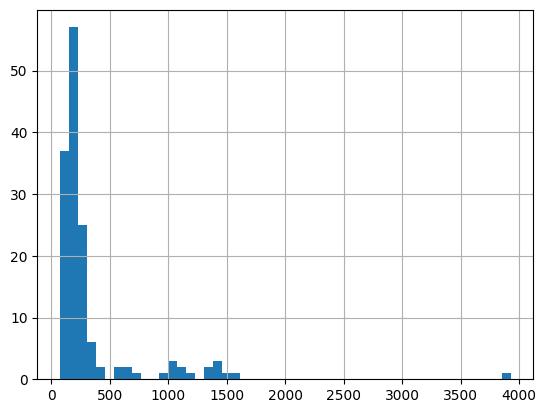

In [42]:
# выброс по стоимости поездок
df_an_scatter['cost'].hist(bins=50)

In [43]:
# ТОП 10 популярных точек назначений
df_an_scatter['b_point'].value_counts().head(10)

b_point
улица Богдана Хмельницкого, 117к1    52
Авиамоторная улица, 43/24            32
Ильинский бульвар, 8                  9
улица Юности, 3                       7
Авиамоторная улица, 55к31             6
проспект Максима Горького, 24         5
Дубравная улица, 5к1                  5
Радужная улица, 1к1                   4
Железнодорожный вокзал                4
V-lounge                              4
Name: count, dtype: int64

In [44]:
# ТОП 10 популярных маршрутов
df_an_scatter.groupby(['a_point', 'b_point']).size().sort_values(ascending=False).head(10)

a_point                            b_point                          
Авиамоторная улица, 55к31          Авиамоторная улица, 43/24            31
Радужная улица, 1к1                улица Богдана Хмельницкого, 117к1     6
улица Богдана Хмельницкого, 117к1  Дубравная улица, 5к1                  4
                                   проспект Максима Горького, 24         4
                                   V-lounge                              3
                                   Железнодорожный вокзал                3
                                   Место посадки                         3
                                   проспект Максима Горького, 11         3
                                   Радужная улица, 1к1                   2
Привокзальная улица, 1             улица Богдана Хмельницкого, 117к1     2
dtype: int64

In [45]:
# Средний чек и длительность по тарифам
df_an_scatter.groupby('tariff').agg({'cost':'mean', 'in_time':'mean'}).round(2)

C:\Users\nikol\AppData\Local\Temp\ipykernel_33524\3778909430.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_an_scatter.groupby('tariff').agg({'cost':'mean', 'in_time':'mean'}).round(2)


,cost,in_time
tariff,,
Select,549.00,12.33
Share,784.00,27.33
UberX,316.61,13.04


C:\Users\nikol\AppData\Local\Temp\ipykernel_33524\898314334.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_an_scatter.groupby(['year_month', 'tariff']) \


<Axes: title={'center': 'Динамика спроса на тарифы'}, xlabel='year_month'>

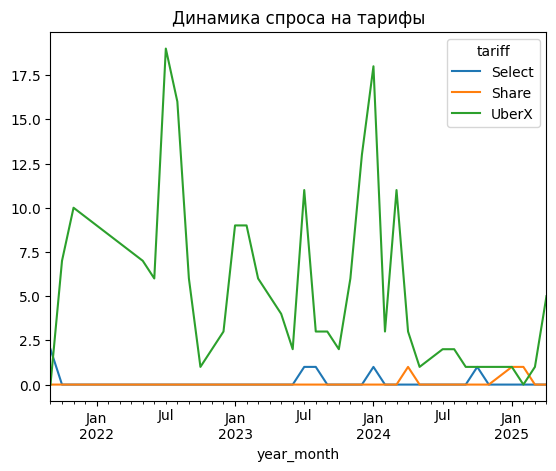

In [46]:
df_an_scatter.groupby(['year_month', 'tariff']) \
             .size() \
             .unstack() \
             .plot(kind='line', title="Динамика спроса на тарифы")

In [47]:
x = df_an_scatter['cost'].sum()
print(f"Общая сумма, потраченная на поездки в Uber за 5 лет пользваония - {int(x)} руб.")

Общая сумма, потраченная на поездки в Uber за 5 лет пользваония - 48874 руб.


<Axes: title={'center': 'Смена стоимости по районам'}, xlabel='b_point'>

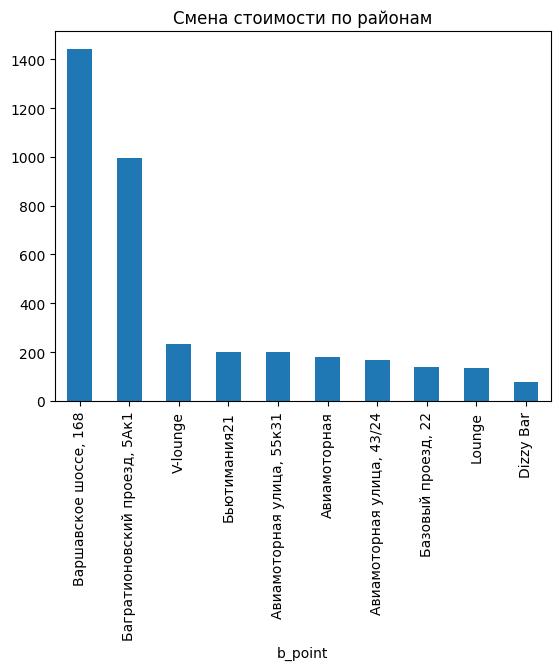

In [48]:
df_an_scatter.groupby('b_point')['cost'] \
             .mean() \
             .head(10) \
             .sort_values(ascending=False) \
             .plot(kind='bar', title=("Смена стоимости по районам"))

- Оплата - оплата банковской картой
- Наличные - оплата наличными средствами
- СПБ - Система быстрых платежей

In [49]:
df_an_scatter['payment_method'].value_counts(normalize=True)

payment_method
Оплата      0.496599
Наличные    0.258503
СПБ         0.244898
Name: proportion, dtype: float64

<Axes: title={'center': 'Относительная частота способов оплаты поездки'}, ylabel='proportion'>

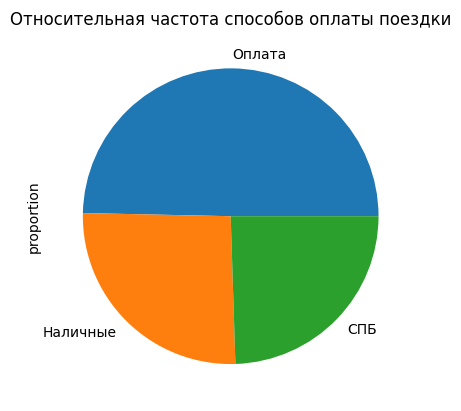

In [50]:
df_an_scatter['payment_method'].value_counts(normalize=True) \
                               .plot(kind='pie', title="Относительная частота способов оплаты поездки")

In [51]:
# Связь оплаты и стоимости/длины поездки
df_an_scatter.groupby('payment_method').agg({'cost': 'mean', 'in_time':'mean'})

C:\Users\nikol\AppData\Local\Temp\ipykernel_33524\915906542.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_an_scatter.groupby('payment_method').agg({'cost': 'mean', 'in_time':'mean'})


,cost,in_time
payment_method,,
Наличные,445.184211,17.473684
Оплата,171.684932,9.301370
СПБ,539.555556,17.666667


In [52]:
x = df_an_scatter['driver'].value_counts().mean()
print(f"Среднее количество поездок на водителя - {x}.")

Среднее количество поездок на водителя - 1.0208333333333333.


In [53]:
# Зависимость времени в пути от мршрута
df_an_scatter.groupby(['a_point','b_point'])['in_time'].mean().sort_values(ascending=False).head(10).reset_index()

,a_point,b_point,in_time
0,"Ильинский бульвар, 8","Шереметьево, Терминал В, Зона вылета",149.0
1,"Павшинский бульвар, 18","улица Камова, 1к1",70.0
2,Дарьял,"Багратионовский проезд, 5Ак1",52.0
3,"улица Вавилова, 81","Ильинский бульвар, 8",45.0
4,"Ленинский проспект, 88","улица Юности, 3",43.5
5,"Рождественская улица, 6А","Горьковское шоссе, 12",39.0
6,"улица Юности, 3","Ореховый бульвар, 7к2",39.0
7,"Ленинский проспект, 87","Ильинский бульвар, 8",38.0
8,"улица Юности, 3","Ленинский проспект, 88",37.0
9,"Новорязанская улица, 16/11с1","улица Юности, 3",30.0


In [54]:
# Зависимость стоимости в пути от мршрута
df_an_scatter.groupby(['a_point','b_point'])['cost'].mean().sort_values(ascending=False).head(10).reset_index()

,a_point,b_point,cost
0,"Ильинский бульвар, 8","Шереметьево, Терминал В, Зона вылета",3930.0
1,"Щёлковское шоссе, 77","улица Юности, 3",1538.0
2,"Ленинский проспект, 88","улица Юности, 3",1459.5
3,Дарьял,"Багратионовский проезд, 5Ак1",1445.0
4,Сунжа,"Варшавское шоссе, 168",1442.0
5,"Ленинский проспект, 87","Ильинский бульвар, 8",1442.0
6,Столички,"Ильинский бульвар, 8",1365.0
7,"Ленинский проспект, 88","Ильинский бульвар, 8",1194.0
8,"улица Вавилова, 81","Ильинский бульвар, 8",1137.0
9,Проспект Вернадского,"Ильинский бульвар, 8",1106.0


In [55]:
# Зависимость стоимости в пути от модели авто
df_an_scatter.groupby('car_model')['cost'].mean().sort_values(ascending=False).head(10).reset_index()

,car_model,cost
0,3,1442.000000
1,Fluence,1194.000000
2,J7,1106.000000
3,Rio,825.352941
4,Octavia,641.750000
5,Sonata,594.500000
6,Duster,418.000000
7,Solaris,360.894737
8,Polo,305.300000
9,Leaf,295.000000


In [56]:
# Зависимость времени в пути от модели авто
df_an_scatter.groupby('car_model')['in_time'].mean().sort_values(ascending=False).head(10).reset_index()

,car_model,in_time
0,Fluence,29.000000
1,3,27.000000
2,Duster,25.000000
3,J7,24.000000
4,Sonata,20.500000
5,Rio,17.933333
6,Polo,17.733333
7,J200,17.333333
8,Cobalt,17.000000
9,Solaris,14.321429


In [57]:
# Зависимость времени в пути от тарифа
df_an_scatter.groupby('tariff')['in_time'].mean().sort_values().reset_index()

C:\Users\nikol\AppData\Local\Temp\ipykernel_33524\3129917501.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_an_scatter.groupby('tariff')['in_time'].mean().sort_values().reset_index()


,tariff,in_time
0,Select,12.333333
1,UberX,13.040000
2,Share,27.333333
